In [1]:
import pandas as pd
import numpy as np

# Load CSV data
file_path = 'csv/trippub.csv'
data = pd.read_csv(file_path)

#REFRENCE CODES: https://nhts.ornl.gov/assets/2017/doc/codebook_v1.2.pdf


# Display basic information about the dataset
print("Number of rows and columns:", data.shape)

Number of rows and columns: (923572, 115)


In [2]:
# Display the first 50 columns
print("First 50 columns:", data.columns[:50])

# Display the next 50 columns
print("\nNext 50 columns:", data.columns[50:100])

# Display the remaining columns
print("\nRemaining columns:", data.columns[100:])

First 50 columns: Index(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME', 'TRVLCMIN',
       'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC', 'VEHID', 'TRWAITTM',
       'NUMTRANS', 'TRACCTM', 'DROP_PRK', 'TREGRTM', 'WHODROVE', 'WHYFROM',
       'LOOP_TRIP', 'TRPHHVEH', 'HHMEMDRV', 'HH_ONTD', 'NONHHCNT', 'NUMONTRP',
       'PSGR_FLG', 'PUBTRANS', 'TRIPPURP', 'DWELTIME', 'TDWKND', 'VMT_MILE',
       'DRVR_FLG', 'WHYTRP1S', 'ONTD_P1', 'ONTD_P2', 'ONTD_P3', 'ONTD_P4',
       'ONTD_P5', 'ONTD_P6', 'ONTD_P7', 'ONTD_P8', 'ONTD_P9', 'ONTD_P10',
       'ONTD_P11', 'ONTD_P12', 'ONTD_P13', 'TDCASEID', 'TRACC_WLK',
       'TRACC_POV', 'TRACC_BUS', 'TRACC_CRL'],
      dtype='object')

Next 50 columns: Index(['TRACC_SUB', 'TRACC_OTH', 'TREGR_WLK', 'TREGR_POV', 'TREGR_BUS',
       'TREGR_CRL', 'TREGR_SUB', 'TREGR_OTH', 'WHYTO', 'TRAVDAY', 'HOMEOWN',
       'HHSIZE', 'HHVEHCNT', 'HHFAMINC', 'DRVRCNT', 'HHSTATE', 'HHSTFIPS',
       'NUMADLT', 'WRKCOUNT', 'TDAYDATE', 'HHRESP', 'LIF_CYC', 'MSACA

HOUSEID     0
PERSONID    0
TDTRPNUM    0
STRTTIME    0
ENDTIME     0
           ..
DTRESDN     0
DTEEMPDN    0
DBHTNRNT    0
DBPPOPDN    0
DBRESDN     0
Length: 115, dtype: int64


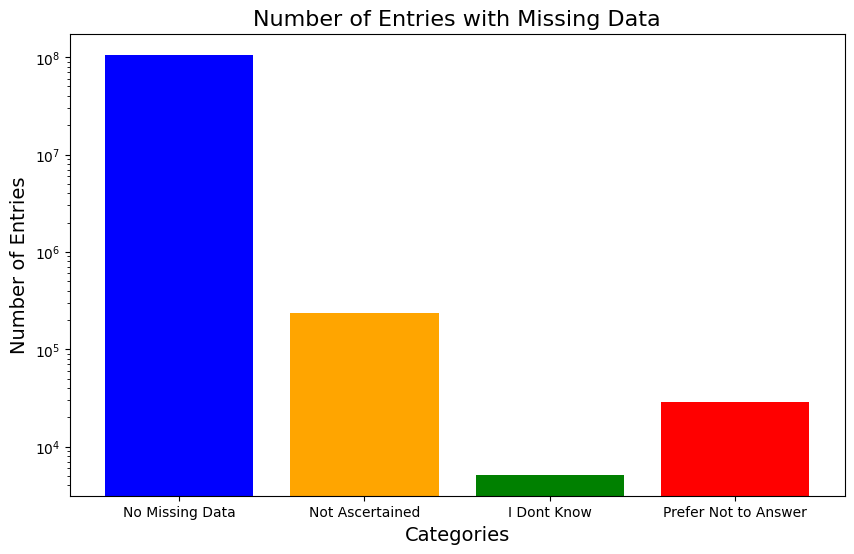

In [3]:
import matplotlib.pyplot as plt
df = data
# Count the occurrences of specific values in each column
count_minus_9 = (df == -9).sum()
count_minus_8 = (df == -8).sum()
count_minus_7 = (df == -7).sum()
count_none_of_those = ((df != -9) & (df != -8) & (df != -7)).sum()
print(count_minus_7)

# Create a bar chart
plt.figure(figsize=(10, 6))
categories = ['No Missing Data', 'Not Ascertained', 'I Dont Know', 'Prefer Not to Answer', ]
counts = [count_none_of_those.sum(), count_minus_9.sum(), count_minus_8.sum(), count_minus_7.sum()]
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.title("Number of Entries with Missing Data", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Number of Entries", fontsize=14)
plt.yscale('log')

# Show the plot
plt.show()

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

columns_to_drop = ['WHYTO', 'WHYFROM', 'TRIPPURP', 'WHYTRP1S', 'WHYTRP90', 'HH_CBSA']  # over half the entries are XXXXX, need to drop this
data_dropped = data.drop(columns=columns_to_drop)
data_dropped = data_dropped.map(lambda x: np.nan if ((isinstance(x, (int, float)) and x < 0) or (isinstance(x, str) and x == '-9')) else x)

# Select columns with 'category' dtype
categorical_columns = data_dropped.select_dtypes(include='object').columns
print(len(categorical_columns))
numerical_columns = data_dropped.select_dtypes(include='number').columns
print(len(numerical_columns))

for c in categorical_columns:
    data_dropped[c] = data_dropped[c].fillna(data_dropped[c].mode())

for n in numerical_columns:
    data_dropped[n] = data_dropped[n].fillna(data_dropped[n].mean())

data_dropped = pd.get_dummies(data_dropped)
data_dropped = data_dropped.replace({True:1, False:0})
    

3
106


In [5]:
# Yes, let's use WHYTRP1S since WHYTO/WHYFROM split into too many categories I think it'll make classification harder.
# TRIPPURP categories are not that useful and WHYTRP90 is from an older study, not necessary any more
target_var = 'WHYTRP1S'

X = data_dropped
y = data[target_var]

print(X.columns)
print(y)

Index(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME', 'TRVLCMIN',
       'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC',
       ...
       'OBHUR_C', 'OBHUR_R', 'OBHUR_S', 'OBHUR_T', 'OBHUR_U', 'DBHUR_C',
       'DBHUR_R', 'DBHUR_S', 'DBHUR_T', 'DBHUR_U'],
      dtype='object', length=167)
0         20
1          1
2          1
3         10
4         20
          ..
923567    10
923568    50
923569    10
923570    40
923571     1
Name: WHYTRP1S, Length: 923572, dtype: int64


In [8]:
X[['DWELTIME', "STRTTIME"]]

,DWELTIME,STRTTIME
0,295.000000,1000
1,120.857073,1510
2,540.000000,700
3,120.857073,1800
4,330.000000,845
...,...,...
923567,283.000000,810
923568,47.000000,1320
923569,240.000000,1415
923570,3.000000,1820


/var/folders/ll/p4zwpbn11q74fh586vs8n9j00000gn/T/ipykernel_17342/2060320936.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='STRTTIME', data=small_data, palette="Set3")


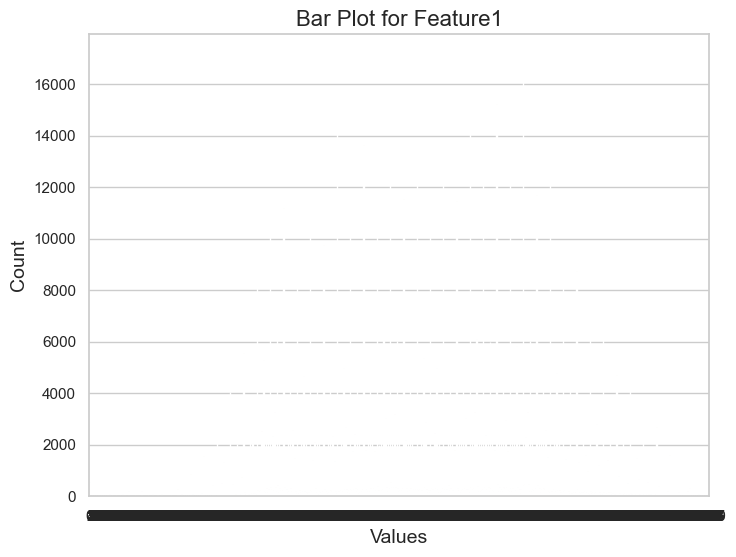

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

small_data=X[['DWELTIME', "STRTTIME", "ENDTIME", "TDTRPNUM", "R_AGE_IMP", "R_AGE"]]
# Set the style of matplotlib

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot for a single feature
plt.figure(figsize=(8, 6))
sns.countplot(x='STRTTIME', data=small_data, palette="Set3")

# Set the title and labels
plt.title("Bar Plot for Feature1", fontsize=16)
plt.xlabel("Values", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Show the plot
plt.show()

In [6]:
rand = np.random.choice(923572, size=50000, replace=False)
X_sel = X.loc[rand,:]
y_sel = y[rand]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sel, y_sel, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [7]:
X_train_scale

array([[ 1.14441008,  0.36305729,  0.30157694, ...,  1.65418786,
        -0.54641228, -0.37784958],
       [-0.8675117 , -0.70512556,  1.15581254, ..., -0.60452626,
        -0.54641228, -0.37784958],
       [ 1.08453665,  0.36305729, -0.97977647, ...,  1.65418786,
        -0.54641228, -0.37784958],
       ...,
       [-0.94003   ,  0.36305729, -0.97977647, ...,  1.65418786,
        -0.54641228, -0.37784958],
       [ 1.07675867, -0.70512556,  3.71851936, ..., -0.60452626,
        -0.54641228,  2.64655578],
       [-0.94211312,  1.43124014, -0.55265867, ...,  1.65418786,
        -0.54641228, -0.37784958]])

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

linreg = LogisticRegressionCV(Cs=5, verbose=1, solver='saga', max_iter=1000, cv=3, tol=1e-3)
linreg.fit(X_train_scale, y_train)
y_pred = linreg.predict(X_test_scale)
print(accuracy_score(y_test, y_pred))

Epoch 1, change: 1.00000000
Epoch 2, change: 0.27960749
Epoch 3, change: 0.13603766
Epoch 4, change: 0.07986952
Epoch 5, change: 0.04995824
Epoch 6, change: 0.03182090
Epoch 7, change: 0.02062480
Epoch 8, change: 0.01356603
Epoch 9, change: 0.01125039
Epoch 10, change: 0.00922585
Epoch 11, change: 0.00771021
Epoch 12, change: 0.00648794
Epoch 13, change: 0.00546543
Epoch 14, change: 0.00467241
Epoch 15, change: 0.00397513
Epoch 16, change: 0.00388590
Epoch 17, change: 0.00394143
Epoch 18, change: 0.00393456
Epoch 19, change: 0.00382784
Epoch 20, change: 0.00363701
Epoch 21, change: 0.00344445
Epoch 22, change: 0.00322922
Epoch 23, change: 0.00299040
Epoch 24, change: 0.00274489
Epoch 25, change: 0.00252183
Epoch 26, change: 0.00230113
Epoch 27, change: 0.00210353
Epoch 28, change: 0.00191284
Epoch 29, change: 0.00173204
Epoch 30, change: 0.00156002
Epoch 31, change: 0.00143041
Epoch 32, change: 0.00129596
Epoch 33, change: 0.00116368
Epoch 34, change: 0.00106602
convergence after 35 ep

<Figure size 1200x600 with 0 Axes>

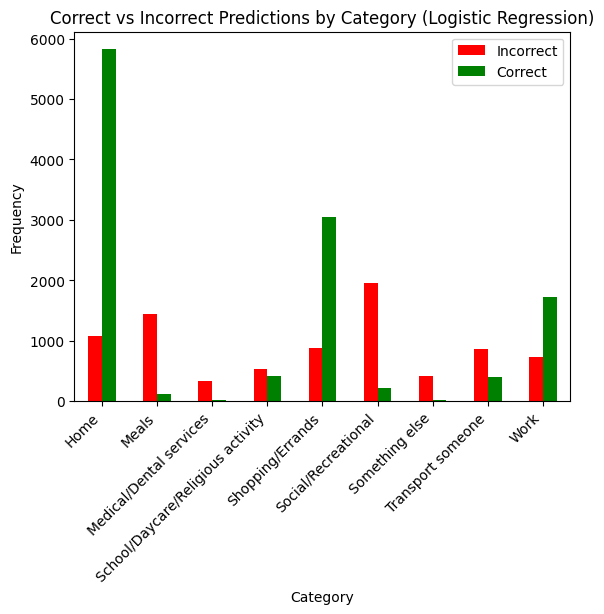

In [11]:
import matplotlib.pyplot as plt
whytrip1s_map_to_string = {
    '1':'Home', 
    '10':'Work', 
    '20':'School/Daycare/Religious activity',
    '30':'Medical/Dental services',
    '40':'Shopping/Errands',
    '50':'Social/Recreational',
    '70':'Transport someone',
    '80':'Meals',
    '97':'Something else'
}
# Create a DataFrame with true labels, predicted labels, correctness indicator, and category
results_df = pd.DataFrame({
    'True_Labels': y_test,
    'Predicted_Labels': y_pred,
    'Correct': y_test == y_pred,
    'Category': y_test.astype(str).map(whytrip1s_map_to_string)
})

# Group by category and correctness, count occurrences
grouped_results = results_df.groupby(['Category', 'Correct']).size().unstack()

# Plot grouped bar graph
plt.figure(figsize=(12, 6))
grouped_results.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.title('Correct vs Incorrect Predictions by Category (Logistic Regression)')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.legend(['Incorrect', 'Correct'])
plt.show()

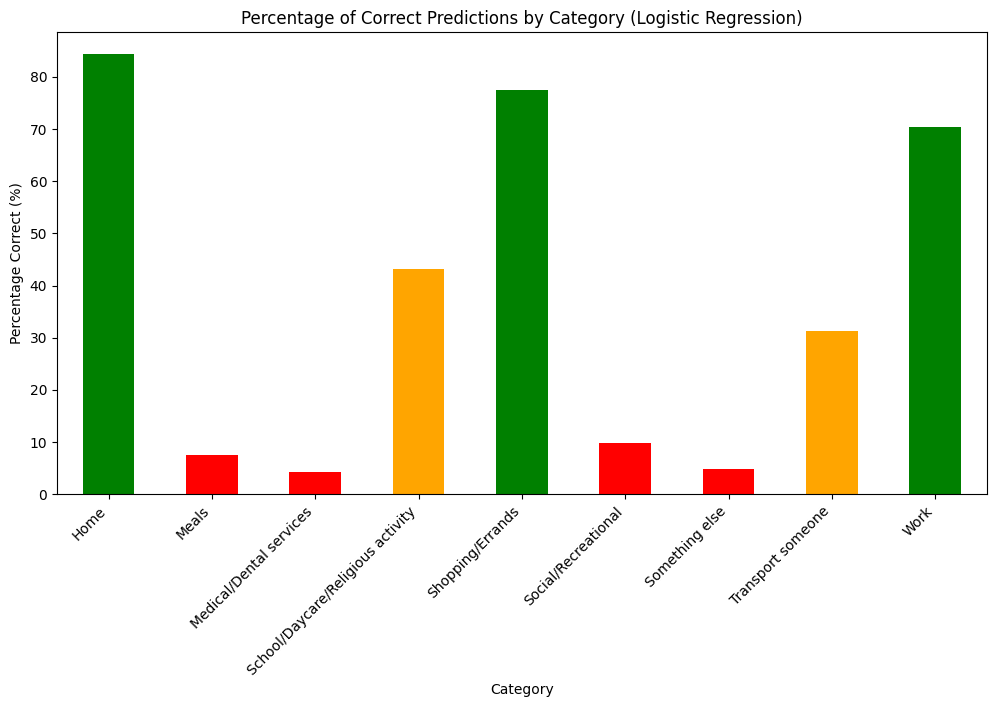

In [12]:
# Calculate the percentage of correct predictions for each category
grouped_results['Percent_Correct'] = (grouped_results[True] / (grouped_results[True] + grouped_results[False]))*100
color_mapping = {
    'red': lambda x: x < 20,
    'orange': lambda x: 20 <= x <= 60,
    'green': lambda x: x > 60
}
colors = [next(key for key, condition in color_mapping.items() if condition(percent)) for percent in grouped_results['Percent_Correct']]

# Plot bar graph for percentage of correct predictions
plt.figure(figsize=(12, 6))
grouped_results['Percent_Correct'].plot(kind='bar', color=colors)
plt.title('Percentage of Correct Predictions by Category (Logistic Regression)')
plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.show()

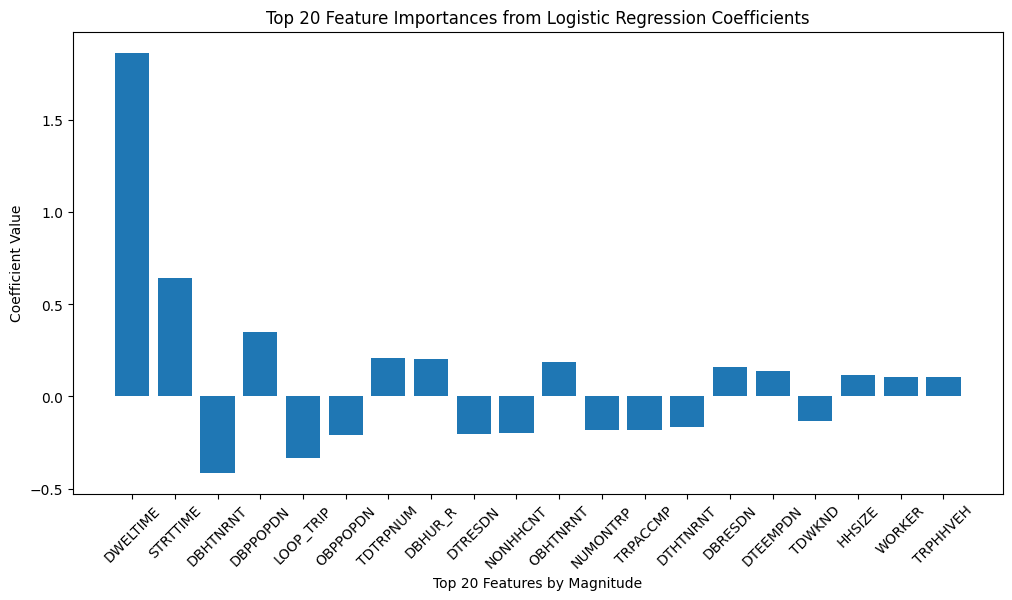

In [17]:
# Get feature importances (coefficients)
feature_importances = linreg.coef_[0]

# Get the indices of the top 20 features by magnitude
top_20_indices = np.abs(feature_importances).argsort()[-20:][::-1]

# Visualize the top 20 features
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_20_indices)), feature_importances[top_20_indices], align='center')
plt.xticks(range(len(top_20_indices)), [X_train.columns[i] for i in top_20_indices], rotation=45)
plt.xlabel('Top 20 Features by Magnitude')
plt.ylabel('Coefficient Value')
plt.title('Top 20 Feature Importances from Logistic Regression Coefficients')
plt.show()

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1]
}

svc = LinearSVC(penalty='l1', dual=False, max_iter=1000, tol=1e-3, verbose=1)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=1, verbose=1)
grid_search.fit(X_train_scale, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LibLinear]...*
optimization finished, #iter = 32
Objective value = 2.589044
#nonzeros/#features = 2/168
*
optimization finished, #iter = 4
Objective value = 1.731171
#nonzeros/#features = 2/168
*
optimization finished, #iter = 3
Objective value = 1.289632
#nonzeros/#features = 1/168
*
optimization finished, #iter = 3
Objective value = 1.072119
#nonzeros/#features = 1/168
*
optimization finished, #iter = 4
Objective value = 2.197782
#nonzeros/#features = 2/168
*
optimization finished, #iter = 3
Objective value = 1.723303
#nonzeros/#features = 1/168
*
optimization finished, #iter = 3
Objective value = 1.378408
#nonzeros/#features = 1/168
*
optimization finished, #iter = 3
Objective value = 1.506818
#nonzeros/#features = 1/168
*
optimization finished, #iter = 3
Objective value = 1.099835
#nonzeros/#features = 1/168
[LibLinear]*
optimization finished, #iter = 5
Objective value = 2.589709
#nonzeros/#features = 3/168
*
optimization

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]................*....*.**
optimization finished, #iter = 219
Objective value = 1860.644013
#nonzeros/#features = 150/168
........**
optimization finished, #iter = 89
Objective value = 575.432477
#nonzeros/#features = 146/168
....................*............**
optimization finished, #iter = 327
Objective value = 404.422376
#nonzeros/#features = 146/168
...........*..*
optimization finished, #iter = 136
Objective value = 196.856803
#nonzeros/#features = 134/168
...........*.....................*.........*..**.**.*.***.**
optimization finished, #iter = 477
Objective value = 1242.109879
#nonzeros/#features = 150/168
...........................*.........................................................*.**.*
optimization finished, #iter = 865
Objective value = 988.965218
#nonzeros/#features = 143/168
....................*................................................................................
optimization finished, #iter = 1000

Objective value = 473.978912
#nonzeros/#fea

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]................*...........*...*.*.*.**.**
optimization finished, #iter = 346
Objective value = 2791.746901
#nonzeros/#features = 157/168
.......................*...*.*
optimization finished, #iter = 272
Objective value = 855.712501
#nonzeros/#features = 146/168
.....................................*....*..*
optimization finished, #iter = 434
Objective value = 607.717996
#nonzeros/#features = 140/168
...............................*....*
optimization finished, #iter = 359
Objective value = 296.385199
#nonzeros/#features = 143/168
..........................*.....*..***
optimization finished, #iter = 335
Objective value = 1872.405520
#nonzeros/#features = 154/168
...........................*..............*..................*...............*..*...*.*..*.*
optimization finished, #iter = 835
Objective value = 1491.023472
#nonzeros/#features = 148/168
..............................*................................................*.*.
optimization finished, #iter = 800
Objective v

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=LinearSVC(dual=False, penalty='l1', tol=0.001,
                                 verbose=1),
             n_jobs=1, param_grid={'C': [0.0001, 0.001, 0.01, 0.1]}, verbose=1)

In [14]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test_scale)
print(accuracy_score(y_test, y_pred))

0.5465


In [10]:
from joblib import dump, load

#dump(grid_search, "linearSVC_grid.joblib")

In [12]:
new_grid = load("linearSVC_grid.joblib")

In [13]:
from sklearn.metrics import accuracy_score

y_pred = new_grid.predict(X_test_scale)
print(accuracy_score(y_test, y_pred))

0.56


<Figure size 1200x600 with 0 Axes>

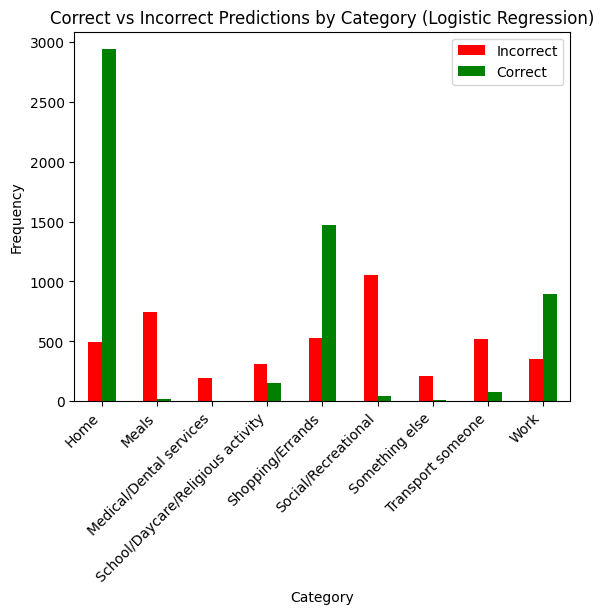

In [14]:
import matplotlib.pyplot as plt
whytrip1s_map_to_string = {
    '1':'Home', 
    '10':'Work', 
    '20':'School/Daycare/Religious activity',
    '30':'Medical/Dental services',
    '40':'Shopping/Errands',
    '50':'Social/Recreational',
    '70':'Transport someone',
    '80':'Meals',
    '97':'Something else'
}
# Create a DataFrame with true labels, predicted labels, correctness indicator, and category
results_df = pd.DataFrame({
    'True_Labels': y_test,
    'Predicted_Labels': y_pred,
    'Correct': y_test == y_pred,
    'Category': y_test.astype(str).map(whytrip1s_map_to_string)
})

# Group by category and correctness, count occurrences
grouped_results = results_df.groupby(['Category', 'Correct']).size().unstack()

# Plot grouped bar graph
plt.figure(figsize=(12, 6))
grouped_results.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.title('Correct vs Incorrect Predictions by Category (Logistic Regression)')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.legend(['Incorrect', 'Correct'])
plt.show()

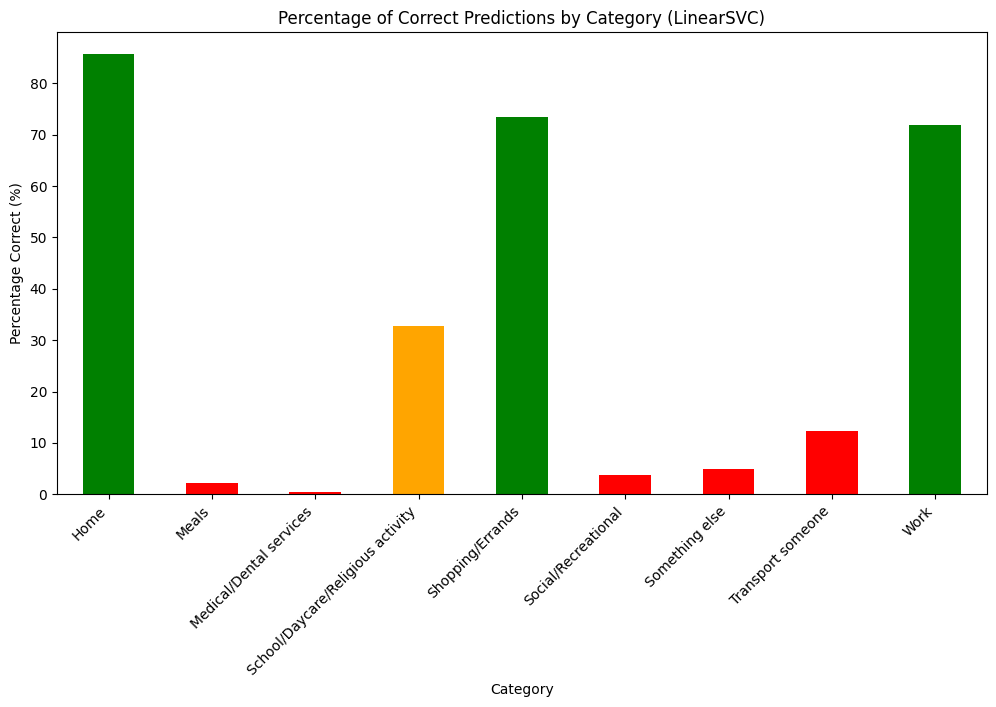

In [15]:
# Calculate the percentage of correct predictions for each category
grouped_results['Percent_Correct'] = (grouped_results[True] / (grouped_results[True] + grouped_results[False]))*100
color_mapping = {
    'red': lambda x: x < 20,
    'orange': lambda x: 20 <= x <= 60,
    'green': lambda x: x > 60
}
colors = [next(key for key, condition in color_mapping.items() if condition(percent)) for percent in grouped_results['Percent_Correct']]

# Plot bar graph for percentage of correct predictions
plt.figure(figsize=(12, 6))
grouped_results['Percent_Correct'].plot(kind='bar', color=colors)
plt.title('Percentage of Correct Predictions by Category (LinearSVC)')
plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.show()

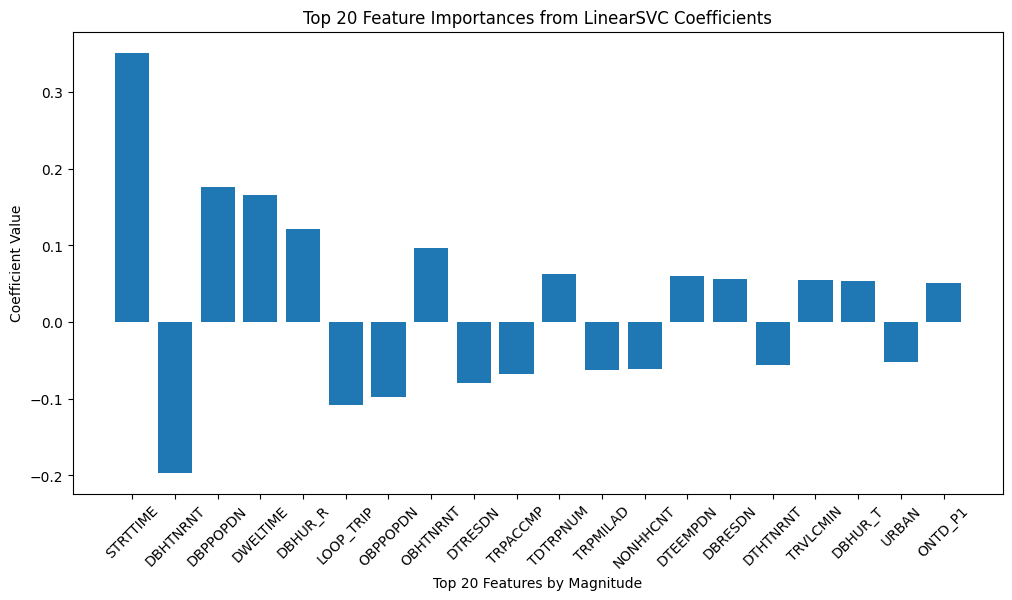

In [17]:
# Get feature importances (coefficients)
feature_importances = new_grid.best_estimator_.coef_[0]

# Get the indices of the top 20 features by magnitude
top_20_indices = np.abs(feature_importances).argsort()[-20:][::-1]

# Visualize the top 20 features
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_20_indices)), feature_importances[top_20_indices], align='center')
plt.xticks(range(len(top_20_indices)), [X_train.columns[i] for i in top_20_indices], rotation=45)
plt.xlabel('Top 20 Features by Magnitude')
plt.ylabel('Coefficient Value')
plt.title('Top 20 Feature Importances from LinearSVC Coefficients')
plt.show()

In [11]:
from joblib import dump, load

dump(svc, 'LinearSVC_l1_C1.joblib')

['LinearSVC_l1_C1.joblib']

In [12]:
newsvc = load('LinearSVC_l1_C1.joblib')

In [13]:
y_pred = newsvc.predict(X_test_scale)
print(accuracy_score(y_test, y_pred))

0.5590666702758303


In [3]:
np.linspace(0.001, 0.01, 10)

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ])